<a href="https://colab.research.google.com/github/ItishaK/AI_Colab_WS/blob/main/LinearRegressiob_TitanicDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf
from IPython.display import clear_output
from six.moves import urllib

In [78]:
!pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [53]:
!pip install tensorflow-estimator

In [54]:
import tensorflow_estimator as tf_estimator

In [79]:
#Load dataset
train_df = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
test_df = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
pred_train = train_df.pop('survived')
pred_test = test_df.pop('survived')

print(train_df.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  


In [80]:
print(pred_train.head())

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64


In [81]:
print(train_df.loc[0],pred_train.loc[0])

sex                          male
age                          22.0
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object 0


In [82]:
train_df.shape

(627, 9)

In [104]:
train_df.shape[0], test_df.shape[0]

(627, 264)

In [83]:
pred_train.shape

(627,)

<Axes: >

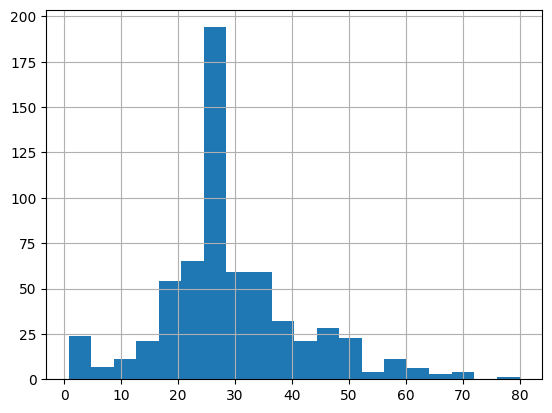

In [84]:
train_df.age.hist(bins=20)

<Axes: >

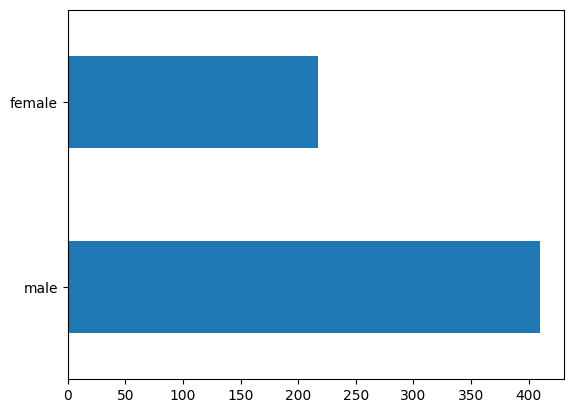

In [85]:
train_df.sex.value_counts().plot(kind='barh')

<Axes: >

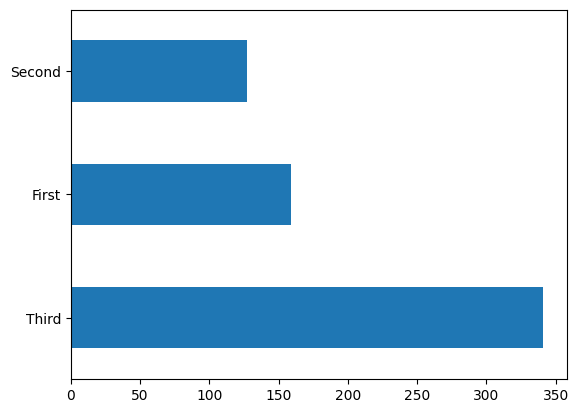

In [87]:
train_df['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '%survive')

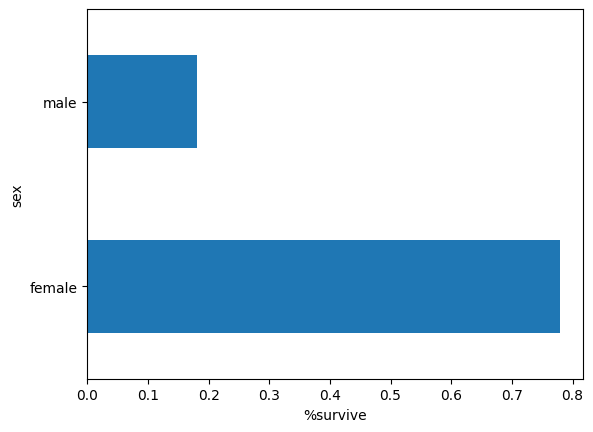

In [88]:
pd.concat([train_df,pred_train],axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('%survive')

In [89]:
train_df.columns

Index(['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck',
       'embark_town', 'alone'],
      dtype='object')

In [90]:
train_df.head(10)

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
5,male,2.0,3,1,21.0750,Third,unknown,Southampton,n
6,female,27.0,0,2,11.1333,Third,unknown,Southampton,n
7,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n
8,female,4.0,1,1,16.7000,Third,G,Southampton,n
9,male,20.0,0,0,8.0500,Third,unknown,Southampton,y


In [91]:
CATEGORICAL_COLS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLS = ['age','fare']

feature_cols = []
for feature_nm in CATEGORICAL_COLS:
  vocab = train_df[feature_nm].unique()
  feature_cols.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_nm,vocab))

for feature_nm in NUMERIC_COLS:
  feature_cols.append(tf.feature_column.numeric_column(feature_nm,dtype=tf.float32))

print(feature_cols)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

In [95]:
train_df['sex'].unique()

array(['male', 'female'], dtype=object)

In [112]:
def main_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def inp_fn():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return inp_fn

train_inp_fn = main_input_fn(train_df, pred_train)
eval_inp_fn = main_input_fn(test_df, pred_test, num_epochs=1, shuffle=False)

In [113]:
print(train_inp_fn)

<function main_input_fn.<locals>.inp_fn at 0x7e7de41a8280>


In [120]:
print(eval_inp_fn)

<function main_input_fn.<locals>.inp_fn at 0x7e7de41a8310>


In [117]:
age_column = feature_cols[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()

array([[19.],
       [28.],
       [21.],
       [28.],
       [19.],
       [17.],
       [33.],
       [35.],
       [28.],
       [34.]], dtype=float32)

In [121]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_cols)

linear_est.train(train_inp_fn)
result = linear_est.evaluate(eval_inp_fn)

print(result['accuracy'])

Instructions for updating:
Use tf.keras instead.


0.7537879


In [122]:
print(result)

{'accuracy': 0.7537879, 'accuracy_baseline': 0.625, 'auc': 0.83587384, 'auc_precision_recall': 0.7826499, 'average_loss': 0.47134474, 'label/mean': 0.375, 'loss': 0.46165478, 'precision': 0.67346936, 'prediction/mean': 0.37797582, 'recall': 0.6666667, 'global_step': 200}


Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


<Axes: title={'center': 'predicted probabilities'}, ylabel='Frequency'>

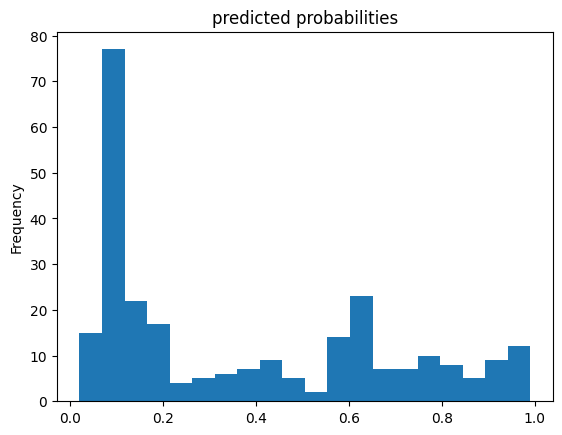

In [123]:
pred_dicts = list(linear_est.predict(eval_inp_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')